In [3]:
# Mount google drive for dataset import

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Install hugging face transformers and datasets for transfer learning

!pip install transformers
!pip install datasets
!pip install numpy requests nlpaug

     |████████████████████████████████| 4.2 MB 6.7 MB/s 
     |████████████████████████████████| 596 kB 59.7 MB/s 
     |████████████████████████████████| 6.6 MB 51.8 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 346 kB 9.6 MB/s 
     |████████████████████████████████| 140 kB 70.6 MB/s 
     |████████████████████████████████| 1.1 MB 62.5 MB/s 
     |████████████████████████████████| 212 kB 75.6 MB/s 
     |████████████████████████████████| 127 kB 73.0 MB/s 
     |████████████████████████████████| 271 kB 74.5 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 144 kB 73.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ER

In [5]:
# Install libraries and check versions

import pandas as pd
import random
import os
import numpy as np
from collections import Counter
import re
import random

from pathlib import Path

import torch
from torch import cuda
from torch import nn

import transformers
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import TrainingArguments, DistilBertConfig, BertConfig
from transformers import Trainer

import datasets
from datasets import Dataset
from datasets import load_metric

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

import nlpaug.augmenter.word as nlpaw
from tqdm import tqdm

import matplotlib.pyplot as plt

print(torch.__version__)
print(transformers.__version__)

1.11.0+cu113
4.19.2


In [6]:
# Import Kaggle datasets from MyDrive
# https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

fake_path = Path('/content/drive/MyDrive/fake_news/Fake.csv')
true_path = Path('/content/drive/MyDrive/fake_news/True.csv')

In [7]:
# Create pandas dataframe for baseline model
# I am dropping the subject and date field to avoid training the model on features
# that won't translate well beyond the limited date range and scope of this dataset

df_fake = pd.read_csv(fake_path, sep=',')
df_fake = df_fake[['title', 'text']]
df_fake["label"] = 0

df_true = pd.read_csv(true_path, sep=',')
df_true = df_true[['title', 'text']]
df_true["label"] = 1

In [8]:
df_fake.head(n=25)

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,0
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,0


In [9]:
df_true.head(n=25)

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",1
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",1
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,1
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,1
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,1


In [10]:
# Combine dataframes and reshuffle 

df = df_true.append(df_fake).sample(frac=1).reset_index(drop=True)

# check the number of rows in the dateframe
print("Number of articles: {} \n".format(df.shape[0]))

df.head(n=25)

# I can already see that "true" articles tend to have a location tag at the beginning
# of the string while "fake" articles do not, the model will learn from that and that
# location tag might be stripped out to improve model robustness for downstream transfer
# learning - but for now I will leave it intact
# data is also very clean so cleaning step will be skipped for now, too

Number of articles: 44898 



,title,text,label
0,Highlights: The Trump presidency on March 2 at...,(Reuters) - Highlights of the day for U.S. Pre...,1
1,Senate rejects new U.S. retirement rule; Obama...,WASHINGTON (Reuters) - The U.S. Senate voted a...,1
2,THUG ANNIVERSARY GETS VIOLENT IN FERGUSON: Cel...,Nothing good can come out of a protest over a ...,0
3,Angry ‘Patriot’ Who Assaulted A Black Woman A...,Imagine if you will that you are one of the du...,0
4,Mark Cuban Hilariously BURNS Trump For Attack...,Donald Trump just got his ass handed to him by...,0
5,Thailand seeks air safety rating upgrade by U....,BANGKOK (Reuters) - Thailand aims to get its a...,1
6,Trump's hopes for Syria safe zones may force d...,WASHINGTON (Reuters) - President Donald Trump’...,1
7,Trump administration moves closer to undoing o...,(Reuters) - The Trump administration on Tuesda...,1
8,WATCH: Will Ferrell Skewers Trump As He Repri...,"Last night, during the official White House Co...",0
9,Sean Spicer Refused To Define ‘Betrayal’ So T...,"On Tuesday, White House Press Secretary Sean S...",0


In [11]:
# Remove duplicate items (Kaggle indicates duplicates exist)
# Titles likely change for exact same article text (esp for fake news), 
# so "text" field ONLY will be scrubbed for duplicates to avoid multiples of
# identical articles with different titles in the dataset
# as suspected, the text field had plenty of duplicates!

df.drop_duplicates(subset = 'text', keep = False, inplace = True, ignore_index=True) 
print("Number of articles after removing duplicates: {} \n".format(df.shape[0]))

Number of articles after removing duplicates: 33506 



In [12]:
df.head(n=25)

,title,text,label
0,Highlights: The Trump presidency on March 2 at...,(Reuters) - Highlights of the day for U.S. Pre...,1
1,Senate rejects new U.S. retirement rule; Obama...,WASHINGTON (Reuters) - The U.S. Senate voted a...,1
2,Angry ‘Patriot’ Who Assaulted A Black Woman A...,Imagine if you will that you are one of the du...,0
3,Mark Cuban Hilariously BURNS Trump For Attack...,Donald Trump just got his ass handed to him by...,0
4,Thailand seeks air safety rating upgrade by U....,BANGKOK (Reuters) - Thailand aims to get its a...,1
5,Trump's hopes for Syria safe zones may force d...,WASHINGTON (Reuters) - President Donald Trump’...,1
6,Trump administration moves closer to undoing o...,(Reuters) - The Trump administration on Tuesda...,1
7,WATCH: Will Ferrell Skewers Trump As He Repri...,"Last night, during the official White House Co...",0
8,Sean Spicer Refused To Define ‘Betrayal’ So T...,"On Tuesday, White House Press Secretary Sean S...",0
9,John McCain’s 2008 Top Campaign Adviser Aband...,A lot has changed in just eight years. The Rep...,0


In [13]:
# Split dataframe into train, validation, and test sets
# As expected, the fake news articles are underrepresented in the dataset

train_df, split_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=True, stratify=df['label'])
dev_df, test_df = train_test_split(split_df, test_size=0.5, random_state=42, shuffle=True, stratify=split_df['label'])

print("Train dataset labels count = ", Counter(train_df['label']))
print("Dev dataset labels count = ", Counter(dev_df['label']))
print("Test dataset labels count = ", Counter(test_df['label']))

Train dataset labels count =  Counter({1: 14685, 0: 8769})
Dev dataset labels count =  Counter({1: 3147, 0: 1879})
Test dataset labels count =  Counter({1: 3147, 0: 1879})


In [14]:
# Training BERT
# Download bert-base-uncased pre-trained model and pretrained tokenizer for sentiment analysis classification

model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to('cuda')
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [15]:
# Preprocess function for tokenization
# The title field will be tokenized for the model training since it is a shorter
# sequence than the full text and will be faster to train

def preprocess_function(examples):
    return tokenizer(examples['title'], truncation=True)

In [16]:
# Create tokenized datasets

train_data = Dataset.from_pandas(train_df)
dev_data = Dataset.from_pandas(dev_df)
test_data = Dataset.from_pandas(test_df)

encoded_dataset_train = train_data.map(preprocess_function, batched=True)
encoded_dataset_dev = dev_data.map(preprocess_function, batched=True)
encoded_dataset_test = test_data.map(preprocess_function, batched=True)

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [17]:
# Rename columns in datasets

columns_to_return = ['input_ids', 'label', 'attention_mask']
encoded_dataset_train.set_format(columns=columns_to_return)
encoded_dataset_dev.set_format(columns=columns_to_return)
encoded_dataset_test.set_format(columns=columns_to_return)

In [18]:
# Specify training args and model parameters

batch_size = 8
metric_name = "f1"
model_name = model_name.split("/")[-1]
task = 'fake_news'
epochs = 3
lr = 1e-5
w_decay = 0.01
warm_steps = 10


args = TrainingArguments(
    f"./save_model/{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    warmup_steps = warm_steps,
    weight_decay=w_decay,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

In [75]:
# Count trainable parameters

def count_parameters(model):
    ''' Count the total number of trainable parameters '''
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("The model has {} trainable parameters".format(num_params))

count_parameters(model)

The model has 109483778 trainable parameters


In [20]:
# Create metrics for training

metric = load_metric('f1')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels, average='macro')

In [21]:
# Create trainer

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset_train,
    eval_dataset=encoded_dataset_dev,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [22]:
# Train model

trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text, title. If __index_level_0__, text, title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 23454
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8796


Epoch,Training Loss,Validation Loss,F1
1,0.080600,0.066670,0.982085
2,0.039300,0.069565,0.983222
3,0.020800,0.085348,0.984691


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text, title. If __index_level_0__, text, title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5026
  Batch size = 8
Saving model checkpoint to ./save_model/bert-base-uncased-finetuned-fake_news/checkpoint-2932
Configuration saved in ./save_model/bert-base-uncased-finetuned-fake_news/checkpoint-2932/config.json
Model weights saved in ./save_model/bert-base-uncased-finetuned-fake_news/checkpoint-2932/pytorch_model.bin
tokenizer config file saved in ./save_model/bert-base-uncased-finetuned-fake_news/checkpoint-2932/tokenizer_config.json
Special tokens file saved in ./save_model/bert-base-uncased-finetuned-fake_news/checkpoint-2932/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argum

TrainOutput(global_step=8796, training_loss=0.058331176604721535, metrics={'train_runtime': 548.6083, 'train_samples_per_second': 128.255, 'train_steps_per_second': 16.033, 'total_flos': 896532421143120.0, 'train_loss': 0.058331176604721535, 'epoch': 3.0})

In [60]:
# Generate predictions from best model

# Baseline model - test set
predictions = trainer.predict(encoded_dataset_test)
bert_preds = np.argmax(predictions.predictions, axis=-1)

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text, token_type_ids, title. If __index_level_0__, text, token_type_ids, title are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5026
  Batch size = 8


In [61]:
# Function to create dataframe on test dataset to assess performance

def make_test_df(encoded_dataset, preds):
  # Create dictionary and populate
  results = {'text':[], 'true':[],'preds':[]}
  # num_samples random values in the range of len
  for i in range(len(encoded_dataset_test)):
    results['text'].append(encoded_dataset_test['text'][i])
    results['true'].append(encoded_dataset_test['label'][i])
    results['preds'].append(preds[i])

  # Convert dictionary to pandas dataframe
  results_df = pd.DataFrame.from_dict(results)
  return results_df 

In [62]:
results_bert = make_test_df(encoded_dataset_test, bert_preds)

In [63]:
# Confusion matrix function

def make_conf_matrix(results_df):
  y_pred = np.array(results_df['preds'])
  y_true = np.array(results_df['true'])
  cm = confusion_matrix(y_true, y_pred)

  # Calculate precision, recall, F1, accuracy scores for test data
  precision = precision_score(y_true, y_pred, average='binary')
  print('Precision: %.3f' % precision)
  recall = recall_score(y_true, y_pred, average='binary')
  print('Recall: %.3f' % recall)
  score = f1_score(y_true, y_pred, average='binary')
  print('F-Measure: %.3f' % score)
  acc = accuracy_score(y_true, y_pred)
  print('Accuracy: %.3f' % acc)
  roc = roc_auc_score(y_true=y_true, y_score=y_pred)
  print('ROC AUC Score: %.3f' %roc)

  # Show confusion matrix display
  CM = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
  plt.show()

Precision: 0.987
Recall: 0.992
F-Measure: 0.989
Accuracy: 0.987
ROC AUC Score: 0.985


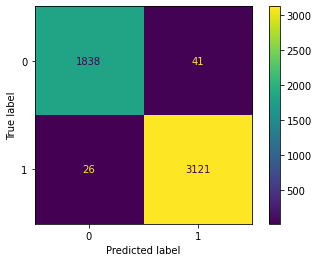

In [64]:
make_conf_matrix(results_bert)

In [65]:
submission = test_df.copy()
submission['preds'] = bert_preds

In [66]:
# Articles that were true but predicted to be fake

temp_df = submission[(submission["label"]==1) & (submission["preds"]==0)]
temp_df.reset_index(drop=True, inplace=True)
temp_df.head(n=30)

,title,text,label,preds
0,Is the sky blue? Depends on what Donald Trump ...,NEW YORK/WASHINGTON (Reuters) - Republicans g...,1,0
1,Burr: Nunes stepped aside to protect Russia pr...,WASHINGTON (Reuters) - The chairman of the Sen...,1,0
2,Teenage IS supporter guilty of plotting attack...,LONDON (Reuters) - A British teenager was foun...,1,0
3,Kentucky man arrested in assault on Senator Ra...,LOUISVILLE/WASHINGTON (Reuters) - A man has be...,1,0
4,"Rice aides, Powell got classified info on pers...",WASHINGTON (Reuters) - Former U.S. Secretary o...,1,0
5,Protesters keeping kids away from Cleveland Re...,(Reuters) - A Milwaukee-based immigrants right...,1,0
6,EU workers drift from Britain just as restaura...,LONDON (Reuters) - Business is booming for Pau...,1,0
7,Trump sounds off on abortion; criticism comes ...,WASHINGTON (Reuters) - Republican presidential...,1,0
8,Mob boss and mass murderer Riina dies of natur...,"ROME (Reuters) - Salvatore Toto Riina, the S...",1,0
9,Trump takes potential VP running mates for tes...,WASHINGTON (Reuters) - Donald Trump is taking ...,1,0


In [67]:
# Articles that were fake but predicted to be true

temp_df = submission[(submission["label"]==0) & (submission["preds"]==1)]
temp_df.reset_index(drop=True, inplace=True)
temp_df.head(n=35)

,title,text,label,preds
0,Catholic Insurance Company Refused To Allow W...,It s not even a slight exaggeration to say tha...,0,1
1,Michael Jordan Condemns North Carolina Anti-L...,North Carolina Republicans just got slam-dunke...,0,1
2,Global Forecasting Service Rates Trump As Hig...,The world no longer sees Donald Trump as a jok...,0,1
3,Trump Declares War On NFL In Early Morning Tw...,Donald Trump is now obsessed with attacking th...,0,1
4,Trump Admits Democrats Are Hurting His Feelin...,Everyone knows Donald Trump is a thin-skinned ...,0,1
5,Baltimore Braces For Chaos: Mistrial Declared ...,The jurors in the Freddie Gray case were deadl...,0,1
6,Idaho Republicans Push Bill To Let Teachers U...,Students in Idaho are one vote away from havin...,0,1
7,Energy Department To Close Office Of Internat...,In response to the U.S. withdrawing from the P...,0,1
8,More Networks Join in the Boycott of New Trum...,If you were not ready to give thought to anyth...,0,1
9,Russian Lawyer Drops Bomb On Donald Trump Jr....,"For the first time in my adult life, I m happy...",0,1


In [43]:
# Compare distibert model performnce to BERT

# Training distilbert
# Download distilbert-base-uncased pre-trained model and pretrained tokenizer for sentiment analysis classification

model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to('cuda')
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

https://huggingface.co/distilbert-base-uncased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpulqiruh3


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
creating metadata file for /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.0

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
creating metadata file for /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias',

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
creating metadata file for /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_r

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-unca

In [44]:
# Use same pre-precess function as before tokenizing on "title"

# Create tokenized datasets

encoded_dataset_train_2 = train_data.map(preprocess_function, batched=True)
encoded_dataset_dev_2 = dev_data.map(preprocess_function, batched=True)
encoded_dataset_test_2 = test_data.map(preprocess_function, batched=True)

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [45]:
# Rename columns in datasets

encoded_dataset_train_2.set_format(columns=columns_to_return)
encoded_dataset_dev_2.set_format(columns=columns_to_return)
encoded_dataset_test_2.set_format(columns=columns_to_return)

In [46]:
# Use same model paramters are before with BERT model
# Count trainable parameters for distilbert model

num_params = count_parameters(model)
print("The model has {} trainable parameters".format(num_params))

The model has 66955010 trainable parameters


In [48]:
# Create trainer for distilbert

distil_trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset_train_2,
    eval_dataset=encoded_dataset_dev_2,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [49]:
# Train model

distil_trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text, title. If __index_level_0__, text, title are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 23454
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8796


Epoch,Training Loss,Validation Loss,F1
1,0.084100,0.079461,0.980801
2,0.048400,0.072866,0.983215
3,0.023100,0.086056,0.983612


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text, title. If __index_level_0__, text, title are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5026
  Batch size = 8
Saving model checkpoint to ./save_model/bert-base-uncased-finetuned-fake_news/checkpoint-2932
Configuration saved in ./save_model/bert-base-uncased-finetuned-fake_news/checkpoint-2932/config.json
Model weights saved in ./save_model/bert-base-uncased-finetuned-fake_news/checkpoint-2932/pytorch_model.bin
tokenizer config file saved in ./save_model/bert-base-uncased-finetuned-fake_news/checkpoint-2932/tokenizer_config.json
Special tokens file saved in ./save_model/bert-base-uncased-finetuned-fake_news/checkpoint-2932/special_tokens_map.json
The following columns in the evaluation set don't have a corresp

TrainOutput(global_step=8796, training_loss=0.06564364784573794, metrics={'train_runtime': 305.7679, 'train_samples_per_second': 230.116, 'train_steps_per_second': 28.767, 'total_flos': 451373346806352.0, 'train_loss': 0.06564364784573794, 'epoch': 3.0})

In [70]:
# Generate predictions from best model

# Distilbert model - test set
predictions = distil_trainer.predict(encoded_dataset_test_2)
distil_preds = np.argmax(predictions.predictions, axis=-1)

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text, title. If __index_level_0__, text, title are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5026
  Batch size = 8


In [71]:
results_distil = make_test_df(encoded_dataset_test_2, distil_preds)

Precision: 0.987
Recall: 0.992
F-Measure: 0.989
Accuracy: 0.987
ROC AUC Score: 0.985


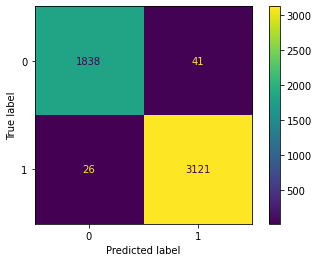

In [72]:
make_conf_matrix(results_distil)

In [68]:
# BERT model is a better fit to the dataset
# Now time to try modeling the "text" field to see if a full article is a 
# better predictor (training time will be large)

model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to('cuda')
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

# Preprocess function for tokenization
# The text field will be tokenized for the model training

def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

encoded_dataset_train_3 = train_data.map(preprocess_function, batched=True)
encoded_dataset_dev_3 = dev_data.map(preprocess_function, batched=True)
encoded_dataset_test_3 = test_data.map(preprocess_function, batched=True)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [73]:
# Rename columns in datasets

encoded_dataset_train_3.set_format(columns=columns_to_return)
encoded_dataset_dev_3.set_format(columns=columns_to_return)
encoded_dataset_test_3.set_format(columns=columns_to_return)

In [76]:
# Create trainer, set epochs = 2 to cut down on training time

epochs = 2

args = TrainingArguments(
    f"./save_model/{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    warmup_steps = warm_steps,
    weight_decay=w_decay,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

count_parameters(model)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The model has 109483778 trainable parameters


In [77]:
# Create trainer

trainer_bert = Trainer(
    model,
    args,
    train_dataset=encoded_dataset_train_3,
    eval_dataset=encoded_dataset_dev_3,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [78]:
# Train model

trainer_bert.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text, title. If __index_level_0__, text, title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 23454
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5864


Epoch,Training Loss,Validation Loss,F1
1,0.001500,0.003069,0.999575
2,0.000000,0.003327,0.999575


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text, title. If __index_level_0__, text, title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5026
  Batch size = 8
Saving model checkpoint to ./save_model/bert-base-uncased-finetuned-fake_news/checkpoint-2932
Configuration saved in ./save_model/bert-base-uncased-finetuned-fake_news/checkpoint-2932/config.json
Model weights saved in ./save_model/bert-base-uncased-finetuned-fake_news/checkpoint-2932/pytorch_model.bin
tokenizer config file saved in ./save_model/bert-base-uncased-finetuned-fake_news/checkpoint-2932/tokenizer_config.json
Special tokens file saved in ./save_model/bert-base-uncased-finetuned-fake_news/checkpoint-2932/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argum

TrainOutput(global_step=5864, training_loss=0.0064626929704684356, metrics={'train_runtime': 2799.1348, 'train_samples_per_second': 16.758, 'train_steps_per_second': 2.095, 'total_flos': 1.233089694273792e+16, 'train_loss': 0.0064626929704684356, 'epoch': 2.0})

In [79]:
# Generate predictions from best model

# BERT model on "text" - test set
predictions = trainer_bert.predict(encoded_dataset_test_3)
bert_text_preds = np.argmax(predictions.predictions, axis=-1)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text, title. If __index_level_0__, text, title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5026
  Batch size = 8


In [80]:
results_bert_text = make_test_df(encoded_dataset_test_3, bert_text_preds)

Precision: 1.000
Recall: 0.999
F-Measure: 1.000
Accuracy: 1.000
ROC AUC Score: 1.000


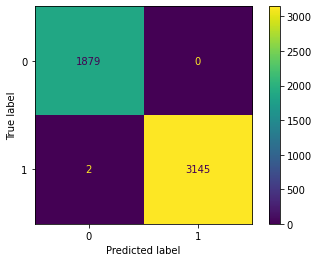

In [81]:
make_conf_matrix(results_bert_text)

In [84]:
submission2 = test_df.copy()
submission2['preds'] = bert_text_preds

# Articles that were true but predicted to be fake

temp_df = submission2[(submission2["label"]==1) & (submission2["preds"]==0)]
temp_df.reset_index(drop=True, inplace=True)
temp_df.head()

,title,text,label,preds
0,Factbox: Trump Supreme Court appointee to affe...,"Neil Gorsuch, President Donald Trump’s appoint...",1,0
1,U.S. intelligence agencies feud with Republica...,Republican members of Congress are complaining...,1,0
